Импортируем нужные библиотеки

In [1]:
import warnings
from sched import scheduler

warnings.filterwarnings("ignore")

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms as T

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")
plt.rcParams.update({'font.size': 15})

import tqdm.auto as tqdm
import wandb

import os
from PIL import Image

Выбираем device для обучения

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else ('mps:0' if torch.mps.is_available() else 'cpu:0')
device

'mps:0'

Собираем кастомный датасет с heatmap

In [3]:
def generate_heatmaps(keypoints, height, width, sigma=2, downsample=4):
    num_points = keypoints.shape[0]
    h, w = height // downsample, width // downsample
    heatmaps = np.zeros((num_points, h, w), dtype=np.float32)

    for i, (x, y, v) in enumerate(keypoints.numpy()):
        if v == 0:
            continue

        # Исправляем масштабирование координат
        x = x * w
        y = y * h

        ul = int(np.floor(x - 3 * sigma)), int(np.floor(y - 3 * sigma))
        br = int(np.ceil(x + 3 * sigma)), int(np.ceil(y + 3 * sigma))

        if ul[0] >= w or ul[1] >= h or br[0] < 0 or br[1] < 0:
            continue

        x_range = np.arange(ul[0], br[0] + 1)
        y_range = np.arange(ul[1], br[1] + 1)
        xx, yy = np.meshgrid(x_range, y_range)

        d = (xx - x) ** 2 + (yy - y) ** 2
        g = np.exp(-d / (2 * sigma ** 2))

        xx_idx = np.clip(x_range, 0, w - 1)
        yy_idx = np.clip(y_range, 0, h - 1)
        heatmaps[i][yy_idx[:, None], xx_idx] = np.maximum(
            heatmaps[i][yy_idx[:, None], xx_idx], g[:len(yy_idx), :len(xx_idx)]
        )

    return torch.from_numpy(heatmaps)

In [95]:
class HandPointDataset(Dataset):
    def __init__(self, img_dir, lbl_dir, split='train', transform=None, sigma=2, downsample=4):
        self.img_dir = os.path.join(img_dir, split)
        self.lbl_dir = os.path.join(lbl_dir, split)
        self.sigma = sigma
        self.downsample = downsample
        self.transform = transform

        self.image_files = sorted(os.listdir(self.img_dir))
        self.label_files = sorted(os.listdir(self.lbl_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        base_name, _ = os.path.splitext(img_name)
        lbl_path = os.path.join(self.lbl_dir, base_name + ".txt")

        with open(lbl_path, "r") as f:
            parts = list(map(float, f.read().strip().split()))[5:]

        keypoints = torch.tensor(parts, dtype=torch.float32).view(-1, 3)

        if self.transform:
            image = self.transform(image)

        heatmaps = generate_heatmaps(keypoints, 224, 224, sigma=self.sigma, downsample=self.downsample)

        return image, heatmaps

Собираем дата лоудеры

In [96]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..")) # текущая рабочая директория
train_img_dir = os.path.join(BASE_DIR, "hand-keypoints/images")
train_lbl_dir = os.path.join(BASE_DIR, "hand-keypoints/labels")

val_img_dir = os.path.join(BASE_DIR, "hand-keypoints/images")
val_lbl_dir = os.path.join(BASE_DIR, "hand-keypoints/labels")

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = HandPointDataset(train_img_dir, train_lbl_dir, split="train", transform=transform)
val_dataset = HandPointDataset(val_img_dir, val_lbl_dir, split="val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

Смотрим данные

In [111]:
image, heatmaps = next(iter(train_loader))
image.shape, heatmaps.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 21, 56, 56]))

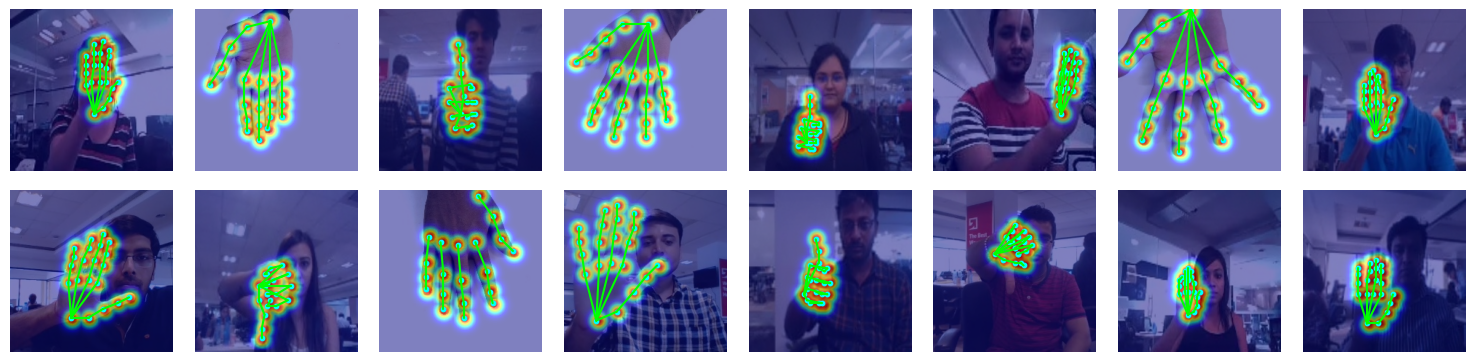

In [114]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
k = 0

skeleton = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9, 10), (10, 11), (11, 12),
    (0, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20)
]

downsample = 4
threshold = 0.001  # порог для отсутствия ключевой точки

for j in range(rows):
    for i in range(cols):
        if k >= len(image):
            break
        ax = fig.add_subplot(rows, cols, j * cols + i + 1)
        ax.axis('off')

        # Берём k-е изображение и heatmaps
        img_tensor = image[k]
        heatmap_tensor = heatmaps[k]

        # Преобразуем изображение в numpy
        img_np = np.transpose(img_tensor.cpu().numpy(), (1, 2, 0))

        # Убираем нормализацию (если нужно)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        ax.imshow(img_np)

        # Правильно берём максимум по ключевым точкам
        heatmap_sum = heatmap_tensor.max(dim=0)[0].cpu().numpy()

        # Масштабируем heatmap к размеру изображения
        heatmap_sum_resized = np.array(
            Image.fromarray(heatmap_sum).resize((img_np.shape[1], img_np.shape[0]), resample=Image.BILINEAR)
        )


        ax.imshow(heatmap_sum_resized, cmap='jet', alpha=0.5)

        # Извлекаем координаты ключевых точек из heatmap
        kp_from_heatmap = []
        scale_x = img_np.shape[1] / heatmap_tensor.shape[2]
        scale_y = img_np.shape[0] / heatmap_tensor.shape[1]

        for h in heatmap_tensor:
            h_np = h.cpu().numpy()
            max_val = h_np.max()

            if max_val < threshold:
                kp_from_heatmap.append((0, 0))  # точка отсутствует
            else:
                y, x = np.unravel_index(np.argmax(h_np), h_np.shape)
                kp_from_heatmap.append((x * scale_x, y * scale_y))

        kp_from_heatmap = np.array(kp_from_heatmap)

        # Рисуем скелет
        for start, end in skeleton:
            if (start < len(kp_from_heatmap) and end < len(kp_from_heatmap) and
                not (kp_from_heatmap[start] == (0, 0)).all() and
                not (kp_from_heatmap[end] == (0, 0)).all()):
                x_vals = [kp_from_heatmap[start][0], kp_from_heatmap[end][0]]
                y_vals = [kp_from_heatmap[start][1], kp_from_heatmap[end][1]]
                ax.plot(x_vals, y_vals, c='lime', linewidth=1.5)

        # heatmap точки
        for x, y in kp_from_heatmap:
            if (x, y) != (0, 0):
                ax.scatter(x, y, s=10, c='cyan', marker='o')

        k += 1

plt.tight_layout()
plt.show()

Функции для обучения

In [131]:
def ncc(logit, target): # метрика качества heatmap
    logit = logit - logit.mean(dim=[2, 3], keepdim=True)
    target = target - target.mean(dim=[2, 3], keepdim=True)
    numerator = (logit * target).sum(dim=[2, 3])
    denominator = torch.sqrt((logit ** 2).sum(dim=[2, 3]) * (target ** 2).sum(dim=[2, 3]) + 1e-6)
    return (numerator / denominator).mean().item()

In [132]:
def train_epoch(model, optimizer, criterion, scheduler=None):
    loss_log, nnc_log = [], []

    model.train()
    for batch_num, (batch_image, batch_heatmaps) in enumerate(train_loader):
        batch_image = batch_image.to(device, pin_memory=True)
        batch_heatmaps = batch_heatmaps.to(device, pin_memory=True)

        optimizer.zero_grad()

        logits = model(batch_image)

        loss = criterion(logits, batch_heatmaps)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        loss_log.append(loss.item())
        nnc_value = nnc(logits, batch_heatmaps)
        nnc_log.append(nnc_value)

        wandb.log({
            "train/batch_loss": loss.item(),
            "train/batch_nnc": nnc_value,
            "batch_num": batch_num
        })

    avg_loss = np.mean(loss_log)
    avg_nnc = np.mean(nnc_log)

    wandb.log({
        "train/epoch_loss": avg_loss,
        "train/epoch_nnc": avg_nnc
    })

    return avg_loss, avg_nnc

In [133]:
def val_epoch(model, criterion):
    loss_log, nnc_log = [], []

    model.train()
    for batch_num, (batch_image, batch_heatmaps) in enumerate(train_loader):
        batch_image = batch_image.to(device, pin_memory=True)
        batch_heatmaps = batch_heatmaps.to(device, pin_memory=True)

        logits = model(batch_image)

        loss = criterion(logits, batch_heatmaps)
        loss_log.append(loss.item())
        nnc_value = nnc(logits, batch_heatmaps)
        nnc_log.append(nnc_value)

        wandb.log({
                "val/batch_loss": loss.item(),
                "val/batch_nnc": nnc_value,
                "val_batch_num": batch_num
            })

    avg_loss = np.mean(loss_log)
    avg_nnc = np.mean(nnc_log)

    wandb.log({
        "val/epoch_loss": avg_loss,
        "val/epoch_nnc": avg_nnc
    })

    return avg_loss, avg_nnc

In [134]:
def train_model(model, optimizer, criterion, scheduler, n_epoch):
    wandb.watch(model, log="all", log_freq=10)

    for epoch in tqdm.trange(n_epoch):
        wandb.log({"epoch": epoch})

        train_loss, train_nnc = train_epoch(model, optimizer, criterion, scheduler)
        val_loss, val_nnc = val_epoch(model, criterion)

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_nnc": train_nnc,
            "val_loss": val_loss,
            "val_nnc": val_nnc
        })

pКонструктор модели

Обучение с логированием